In [5]:
# Load overlay features

from collections.abc import Mapping
from pathlib import Path
from typing import Union

import pandas as pd


def load_and_merge_csvs(
    directory: Union[str, Path],
    rename_map: Mapping[str, str] | None = None,
) -> pd.DataFrame:
    """
    Load all CSV files from a directory, optionally rename columns, and merge
    them row by row into a single DataFrame.

    :param directory: Path to the directory containing CSV files.
    :param rename_map: Mapping from existing column names to new column names.
                      If None, no renaming is applied.
    :return : of objects.
    :return: A pandas DataFrame where rows from all CSV files are concatenated.
    """
    dir_path: Path = Path(directory)
    if not dir_path.is_dir():
        raise NotADirectoryError(f"{dir_path} is not a valid directory.")

    csv_files: list[Path] = sorted(dir_path.glob("*.csv"))
    print(f"Found {len(csv_files)} CSV files.")
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {dir_path}.")

    data_frames: list[pd.DataFrame] = []
    for file in csv_files:
        df: pd.DataFrame = pd.read_csv(file)
        if rename_map:
            df = df.rename(columns=rename_map)
        data_frames.append(df)

    merged_df: pd.DataFrame = pd.concat(data_frames, axis=0, ignore_index=True)
    return merged_df
def remove_outliers_zscore(data: np.ndarray, threshold: float = 3.0) -> np.ndarray:
    """
    Remove rows from `data` where any feature has an absolute z‑score greater than `threshold`.

    :param data: 2‑D array containing numeric samples.
    :param threshold: Absolute z‑score cut‑off.
    :return : of objects.
    :return: A new array with the outlier rows removed.
    """
    if data.ndim != 2:
        raise ValueError("`data` must be a 2‑D array.")

    mean: np.ndarray = data.mean(axis=0)
    std: np.ndarray = data.std(axis=0, ddof=0)

    z_scores: np.ndarray = (data - mean) / std
    mask: np.ndarray = np.all(np.abs(z_scores) < threshold, axis=1)

    return data[mask]


Found 375 CSV files.
Event-log                 Area orange   Area blue        Diff      % inc.
-------------------------------------------------------------------------
Road-Traffic-Fine-Management-Process     23.1529     21.2108      1.9421        9.16
daily_living                  23.1529      6.4367     16.7162      259.70
bpi-c-2019                    23.1529     15.7909      7.3620       46.62
bpi-c-2015                    23.1529      7.2422     15.9108      219.70
bpi-c-2017                    23.1529     16.4384      6.7145       40.85
bpi-c-2012                    23.1529     18.9574      4.1956       22.13
bpi-c-2013                    23.1529      6.5237     16.6292      254.91
sepsis                        23.1529     19.4748      3.6781       18.89


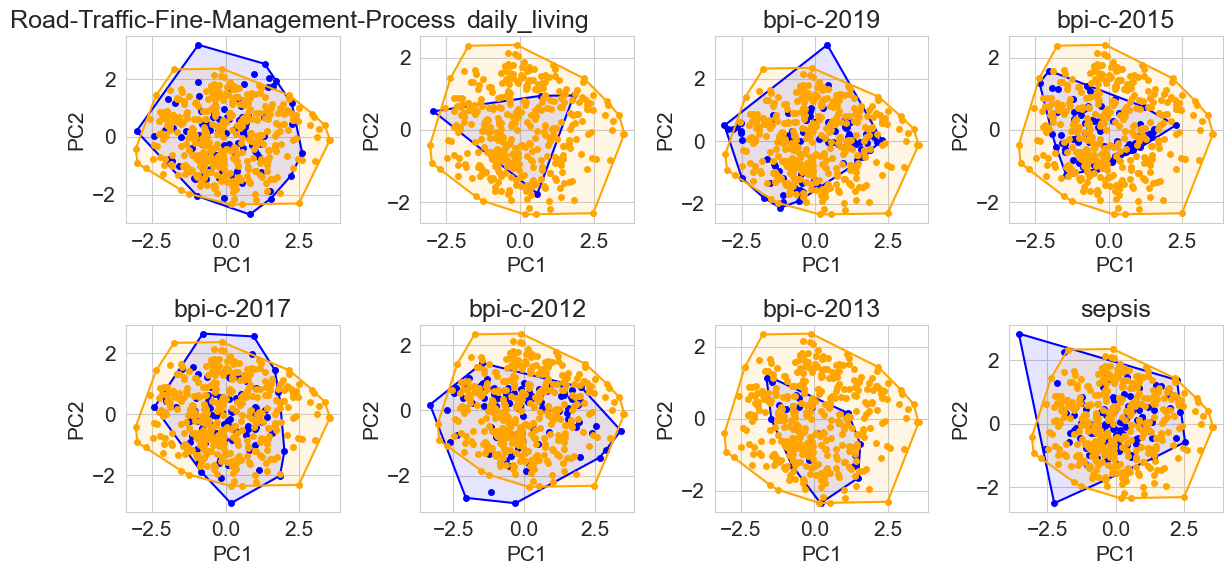

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
from __future__ import annotations

from pathlib import Path
from typing import Mapping

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Constants for plot configuration
FONT_SIZE: int = 15
SUBFIGURE_SIZE: tuple[int, int] = (3, 3)

FOLDER_PATH: Path = Path("static_analysis/")
CSV_FILES: list[Path] = [
    p for p in FOLDER_PATH.glob("*.csv") if "hospital-billing" not in str(p)
]

COLUMNS: list[str] = [
    "activity_appearance_rate",
    "unique_paths_ratio",
    "temporal_dependency",
    "parallel_activity_ratio",
    "long_term_dependencies",
]

RENAME_MAP: Mapping[str, str] = {
    "activity_count_ratio": "activity_appearance_rate",
    "trace_count_measure": "unique_paths_ratio",
    "choice_branching_factor": "temporal_dependency",
    "trace_length_uniformity": "parallel_activity_ratio",
    "long_range_dependency_measure": "long_term_dependencies",
}


def compute_hull(points: np.ndarray) -> ConvexHull | None:
    """
    Build a convex hull for 2-D *points*.

    :param points: Array shaped (n_samples, 2).
    :return : of objects.
    :return: *ConvexHull* instance or *None* if the hull is degenerate.
    """
    if points.shape[0] < 3:
        return None
    try:
        return ConvexHull(points)
    except Exception:
        return None


def hull_area(hull: ConvexHull | None) -> float:
    """
    Area of a 2-D convex hull.

    :param hull: ConvexHull returned by *compute_hull*.
    :return : of objects.
    :return: Area (0.0 if *hull* is *None*).
    """
    return float(getattr(hull, "volume", 0.0)) if hull is not None else 0.0


def percentage_increase(orange: float, blue: float) -> float:
    """
    Percentage increase from *blue* area to *orange* area.

    :param orange: Area of the generator (orange) hull.
    :param blue: Area of the real-log (blue) hull.
    :return : of objects.
    :return: Percentage by which *orange* exceeds *blue* (0.0 if *blue* is 0).
    """
    if blue == 0.0:
        return 0.0
    return (orange - blue) / blue * 100.0


def main() -> None:
    """
    Plot PCA clouds for each static log and print hull-overlap statistics.

    :return : of objects.
    :return: *None*.
    """
    # Apply global font size
    plt.rcParams.update({"font.size": FONT_SIZE})

    overlay_df: pd.DataFrame = load_and_merge_csvs(
        f"{Path.cwd().parent}/output/", RENAME_MAP
    )
    overlay_numeric: pd.DataFrame = (
        overlay_df.select_dtypes(include=[np.number])
        .drop(columns=["activity_appearance_rate"], errors="ignore")
        .dropna()
    )

    overlay_pca: np.ndarray | None = None
    overlay_hull: ConvexHull | None = None
    if len(overlay_numeric) >= 3:
        overlay_scaled: np.ndarray = StandardScaler().fit_transform(overlay_numeric)
        overlay_pca = PCA(n_components=2).fit_transform(overlay_scaled)
        overlay_hull = compute_hull(overlay_pca)

    orange_area: float = hull_area(overlay_hull)

    n_files: int = len(CSV_FILES)
    n_cols: int = 4
    n_rows: int = (n_files + n_cols - 1) // n_cols

    # Compute figure size based on subfigure dimensions
    fig_width: int = SUBFIGURE_SIZE[0] * n_cols
    fig_height: int = SUBFIGURE_SIZE[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axes = axes.flatten()

    header: str = (
        f"{'Event-log':<25s}"
        f"{'Area orange':>12s}"
        f"{'Area blue':>12s}"
        f"{'Diff':>12s}"
        f"{'% inc.':>12s}"
    )
    print(header)
    print("-" * len(header))

    for i, csv_file in enumerate(CSV_FILES):
        df: pd.DataFrame = pd.read_csv(csv_file)
        numeric_df: pd.DataFrame = df.select_dtypes(include=[np.number])[COLUMNS]

        if len(numeric_df) < 3:
            axes[i].set_title(f"{csv_file.stem} (insufficient data)")
            axes[i].axis("off")
            continue

        scaled: np.ndarray = StandardScaler().fit_transform(numeric_df)
        pca_res: np.ndarray = PCA(n_components=2).fit_transform(scaled)
        pca_res = remove_outliers_zscore(pca_res, threshold=3.0)

        axes[i].plot(pca_res[:, 0], pca_res[:, 1], "o", markersize=4, color="blue")

        blue_hull: ConvexHull | None = compute_hull(pca_res)
        blue_area: float = hull_area(blue_hull)

        if blue_hull is not None:
            for simplex in blue_hull.simplices:
                axes[i].plot(pca_res[simplex, 0], pca_res[simplex, 1], "b-")
            axes[i].fill(
                pca_res[blue_hull.vertices, 0],
                pca_res[blue_hull.vertices, 1],
                "blue",
                alpha=0.1,
            )

        if overlay_pca is not None:
            axes[i].plot(
                overlay_pca[:, 0], overlay_pca[:, 1], "o", markersize=4, color="orange"
            )
            if overlay_hull is not None:
                for simplex in overlay_hull.simplices:
                    axes[i].plot(
                        overlay_pca[simplex, 0], overlay_pca[simplex, 1], "orange"
                    )
                axes[i].fill(
                    overlay_pca[overlay_hull.vertices, 0],
                    overlay_pca[overlay_hull.vertices, 1],
                    "orange",
                    alpha=0.1,
                )

        axes[i].set_title(csv_file.stem)
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")

        diff: float = orange_area - blue_area
        pct_inc: float = percentage_increase(orange_area, blue_area)

        print(
            f"{csv_file.stem:<25s}"
            f"{orange_area:>12.4f}"
            f"{blue_area:>12.4f}"
            f"{diff:>12.4f}"
            f"{pct_inc:>12.2f}"
        )

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

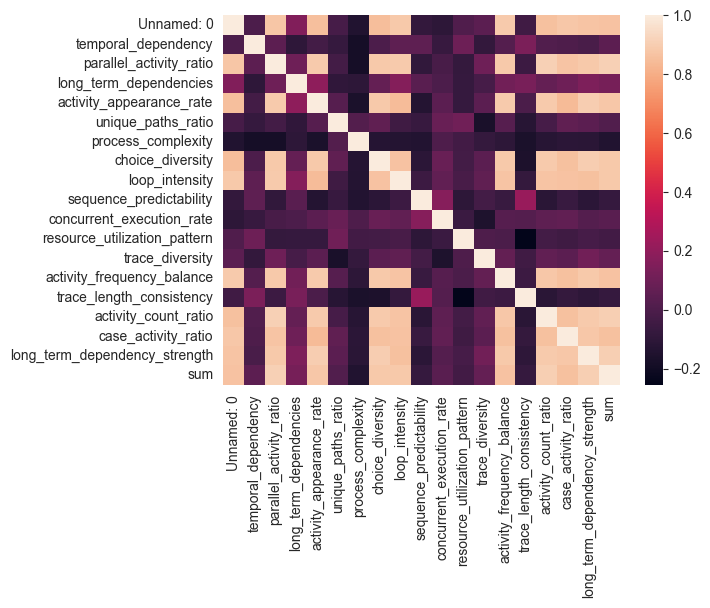

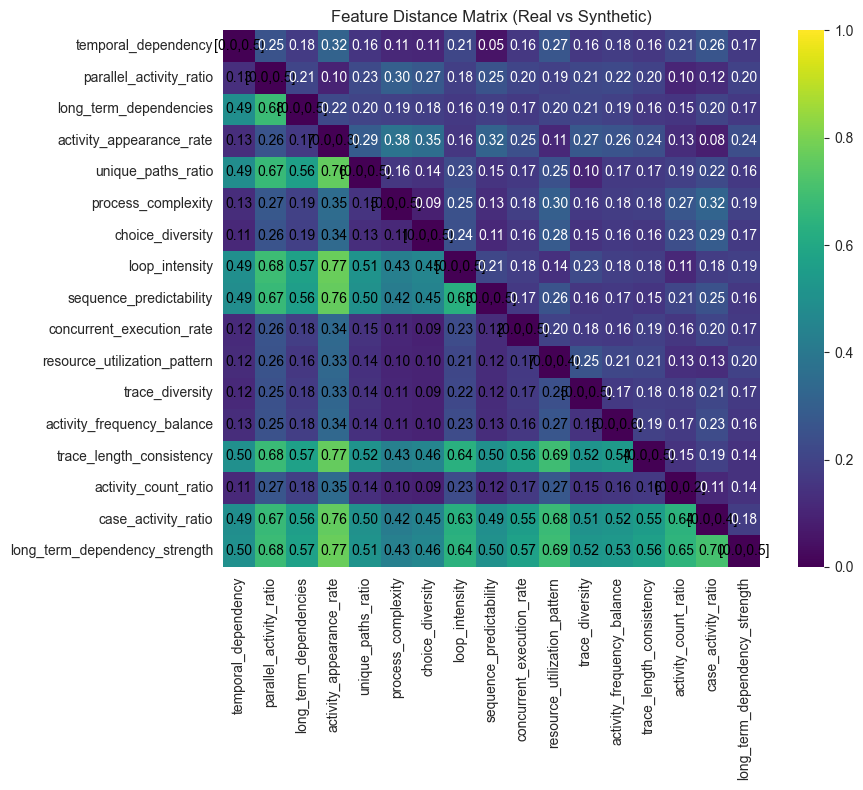

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib import gridspec

# Load the datasets
real_df: pd.DataFrame = pd.read_csv("static_analysis/bpi-c-2019.csv")
synthetic_df: pd.DataFrame = pd.read_csv("stream_features.csv")

corr = synthetic_df.select_dtypes('number').corr()
sns.heatmap(corr)
# Drop non-numeric or unnecessary columns
real_df = real_df.select_dtypes(include=[np.number])
synthetic_df = synthetic_df.select_dtypes(include=[np.number])

# Define target value
target_value: float = 0.9

# Function to calculate mean distance between two sets of features
def compute_mean_distance(a: pd.Series, b: pd.Series) -> float:
    return np.mean(np.abs(a - b))

# Initialize matrices
n_features: int = len(real_df.columns)
avg_dist_matrix: np.ndarray = np.zeros((n_features, n_features))
target_dist_matrices: np.ndarray = np.zeros((n_features, n_features))

# Calculate pairwise distances
for i in range(n_features):
    for j in range(n_features):
        if i < j:
            avg_dist_matrix[i, j] = compute_mean_distance(real_df.iloc[:, i], real_df.iloc[:, j])
        elif i > j:
            target_dist_matrices[i, j] = compute_mean_distance(synthetic_df.iloc[:, i], real_df.iloc[:, j])

# Create diagonal sensible ranges (fake heuristic example)
sensible_ranges = {
    i: f"[{round(real_df.iloc[:, i].min(), 1)},{round(real_df.iloc[:, i].max(), 1)}]" for i in range(n_features)
}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=0, vmax=1)
img = np.zeros((n_features, n_features))

# Fill image array
for i in range(n_features):
    for j in range(n_features):
        if i == j:
            img[i, j] = 0  # visually encode as zero for neutral diagonal
        elif i < j:
            img[i, j] = avg_dist_matrix[i, j]
        else:
            img[i, j] = target_dist_matrices[i, j]

# Plot heatmap
sns.heatmap(img, cmap=cmap, norm=norm, annot=False, square=True, cbar=True, xticklabels=real_df.columns, yticklabels=real_df.columns, ax=ax)

# Annotate upper and lower triangle
for i in range(n_features):
    for j in range(n_features):
        if i < j:
            ax.text(j + 0.5, i + 0.5, f"{avg_dist_matrix[i, j]:.2f}", ha="center", va="center", color="white")
        elif i > j:
            ax.text(j + 0.5, i + 0.5, f"{target_dist_matrices[i, j]:.2f}", ha="center", va="center", color="black")
        elif i == j:
            ax.text(j + 0.5, i + 0.5, sensible_ranges[i], ha="center", va="center", color="black")

ax.set_title("Feature Distance Matrix (Real vs Synthetic)")
plt.tight_layout()
plt.show()




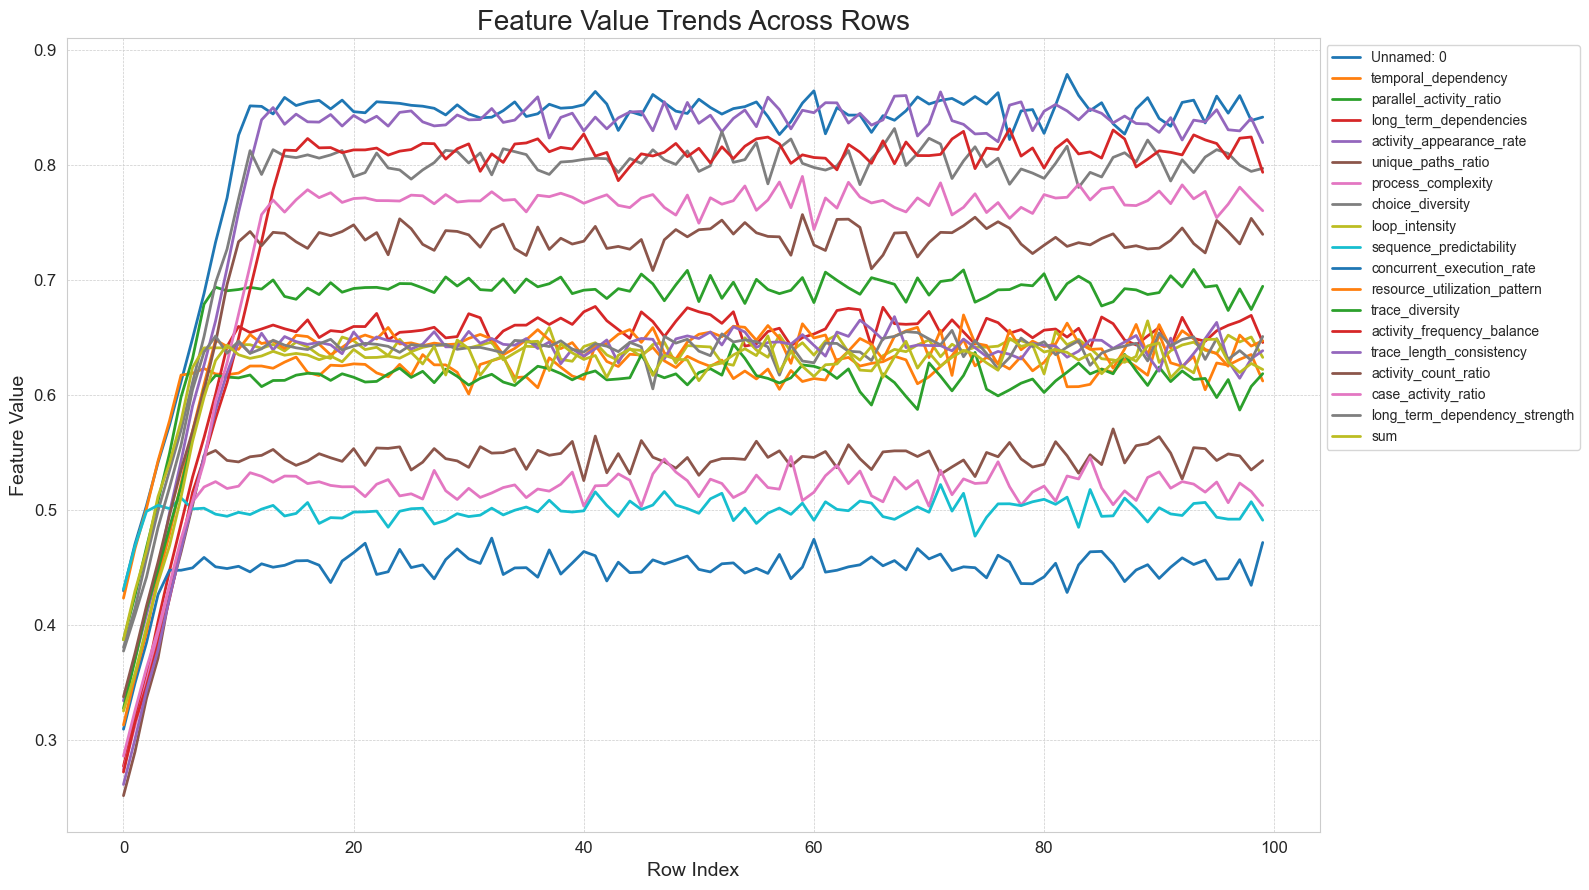

In [37]:
import matplotlib.pyplot as plt

"""
Generates a multi-line plot of feature values across rows.

:param new_df: the modified DataFrame with feature values.
:return: renders the line plot.
"""

# Plot settings
plt.figure(figsize=(16, 9))
x_values: range = range(len(new_df))

# Plot each feature
for col in numeric_cols:
    plt.plot(x_values, new_df[col], label=col, linewidth=2)

# Styling
plt.title("Feature Value Trends Across Rows", fontsize=20)
plt.xlabel("Row Index", fontsize=14)
plt.ylabel("Feature Value", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), fontsize=10, ncol=1)
plt.tight_layout()

plt.show()